In [2]:
import sys
import dotenv
import os
dotenv.load_dotenv()
sys.path.append(os.getenv('MAINDIR'))
from helpers.ds_helpers import X_y_split, open_and_prepare_df
from helpers.models_helpers import plot_results
import numpy as np
from scipy import stats
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
import warnings
import ast
from sklearn.model_selection import train_test_split


warnings.filterwarnings("ignore", category=UserWarning)

2023-05-20 15:04:35.971222: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-20 15:04:35.993724: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-20 15:04:36.297945: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
df = open_and_prepare_df('features')

tokenized_X_list = []

for item in df['nlp_2'].values, df['nlp_3'].values, df['nlp_4'].values, df['nlp_5'].values:
    arr_item = np.array([np.array(ast.literal_eval(item)) for item in item])

    tokenized_X_list.append(arr_item)

tokized_X_tuple = tuple(tokenized_X_list)

NLP_all = np.hstack(tokized_X_tuple)

df['nlp_all'] = NLP_all.tolist()

In [4]:
#Finding optimal hyperparameter

X, y = X_y_split(df, 'nlp_all')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

for alpha in [1, 100, 200, 500, 1000]:
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    print(f'Alpha: {alpha}', round(stats.pearsonr(y_test, pred)[0], 3), round(mean_absolute_error(y_test, pred), 3))

Alpha: 1 0.263 3.339
Alpha: 100 0.474 2.801
Alpha: 200 0.484 2.786
Alpha: 500 0.484 2.832
Alpha: 1000 0.477 2.897


In [5]:
x_strings = ['nlp_2', 'nlp_3', 'nlp_4', 'nlp_5', 'nlp_all']
models = [Ridge(alpha=200)]

In [6]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=8)
for model in models:
    print(model)
    for x_string in x_strings: 
        X, y = X_y_split(df, x_string)

        model_pred = []
        y_main_true = []

        for train_index, test_index in kfold.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            model = model

            model.fit(X_train, y_train)
            prediction = model.predict(X_test)

            model_pred = np.concatenate((model_pred, prediction))
            y_main_true = np.concatenate((y_main_true, y_test))
        
        print(x_string, round(stats.pearsonr(y_main_true, model_pred)[0], 3), \
              round(mean_absolute_error(y_main_true, model_pred), 3))

Ridge(alpha=200)
nlp_2 0.274 2.928
nlp_3 0.369 2.77
nlp_4 0.288 2.91
nlp_5 0.406 2.747
nlp_all 0.476 2.594


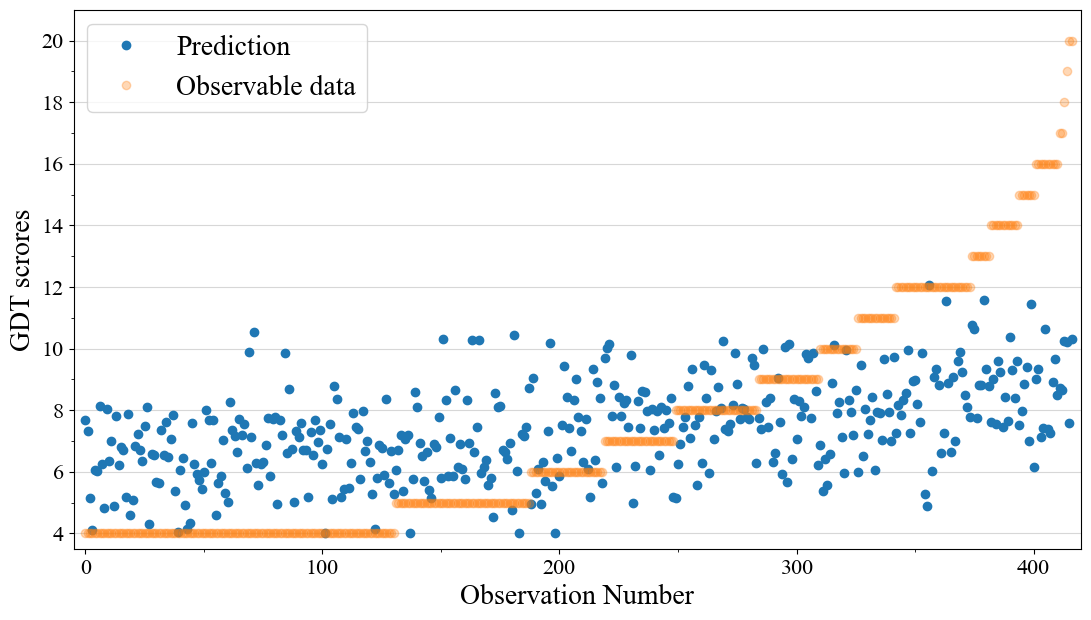

In [7]:
import matplotlib.pyplot as plt

def plot_results(prediction, true_values):
    plt.rcParams["font.family"] = "Times New Roman"
    prediction = [item if item >= 4 else 4 for item in prediction]
    prediction = [item if item <= 20 else 20 for item in prediction]

    answers_tuples = [(y, res) for y, res in zip(true_values, prediction)]
    sorted_tuples = sorted(answers_tuples, key=lambda x: x[0])

    sorted_results = [x[1] for x in sorted_tuples]

    true_values = [x[0] for x in sorted_tuples]
    prediction = [item for item in sorted_results]

    plt.figure(figsize=(13, 7))
    ax = plt.axes()

    ax.set_ylim(3.5, 21)
    ax.set_yticks(range(4, 21, 2))
    ax.set_yticks(range(4, 21, 1), minor=True)

    ax.grid(True, which='major', axis='y',alpha=0.5)
    ax.set_xlim(-5, 420)
    ax.set_xticks(range(0, 440, 100))
    ax.set_xticks(range(0, 440, 50), minor=True)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=12)

    plt.xlabel('Observation Number', fontsize=20)
    plt.ylabel('GDT scrores', fontsize=20)
    
    plt.plot(range(len(prediction)), prediction, 'o', label="Prediction")
    plt.plot(range(len(true_values)), true_values, 'o', alpha=0.3, label='Observable data')
    plt.legend(loc='upper left', fontsize=20)
    plt.show()

plot_results(model_pred, y_main_true)